In [1]:
!pip install path
!pip install trimesh

In [2]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from path import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import trimesh

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
path = Path("C:/Users/carlo/Documents/Courses/DL/ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Reading Data
Data is separated is in the form of x,y,z
Vetices are [x0, y0, z0], etc.

In [4]:
# credit https://stackoverflow.com/questions/31129968/off-files-on-python

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


In [5]:
with open(path/"sofa/train/sofa_0002.off", 'r') as f:
    verts, faces = read_off(f)


In [6]:
verts[:2]
faces[:3]
len(verts)

6433

In [7]:
mesh = trimesh.load_mesh(path/"chair/train/chair_0011.off")
mesh.show()

In [8]:
# credit : https://www.kaggle.com/balraj98/pointnet-for-3d-object-classification-ii-pytorch/code

class PointSampler(object):
    def __init__(self, output_size):
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [9]:
pointcloud = PointSampler(5000)((verts, faces))
pointcloud[:2]

array([[  4.83621057,  31.34241144, -41.80525   ],
       [ 31.61427318,  51.00560736,  26.48532749]])

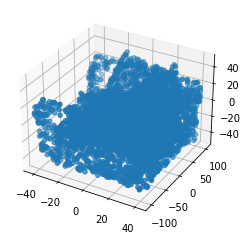

In [10]:
trimesh.points.plot_points(pointcloud)

In [19]:
class Normalize(object):
    def __call__(self, pointcloud):
        return  pointcloud / np.max(np.linalg.norm(pointcloud - np.mean(pointcloud, axis=0), axis=1))
    
class RandRotation_z(object):
    def __call__(self, pointcloud):
        t = random.random() * 2. * math.pi
        m = np.array([[ math.cos(t), -math.sin(t),    0],
                               [ math.sin(t),  math.cos(t),    0],
                               [0,                             0,      1]])
        return  m.dot(pointcloud.T).T
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        return  pointcloud + np.random.normal(0, 0.02, (pointcloud.shape))
class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)

In [20]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [21]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            print(new_dir)
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [22]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [23]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

C:/Users/carlo/Documents/Courses/DL/ModelNet10\bathtub\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\bed\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\chair\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\desk\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\dresser\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\monitor\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\night_stand\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\sofa\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\table\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\toilet\train
C:/Users/carlo/Documents/Courses/DL/ModelNet10\bathtub\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\bed\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\chair\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\desk\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\dresser\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\monitor\test
C:/Users/carlo/Documents/Courses/DL/ModelNet10\nig

In [24]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [25]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [26]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

### PointNet Model

In [27]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
torch.manual_seed(0)

class Transform_Net(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.seq1 = nn.Sequential(
          nn.Conv1d(k, 64, 1),
          nn.BatchNorm1d(64), 
          nn.ReLU(),
          nn.Conv1d(64, 128,1),
          nn.BatchNorm1d(128), 
          nn.ReLU(), 
          nn.Conv1d(128, 1024, 1),
          nn.BatchNorm1d(1024), 
          nn.ReLU()
        )
        self.seq2 = nn.Sequential(
          nn.Linear(1024,512),
          nn.BatchNorm1d(512), 
          nn.ReLU(),
          nn.Linear(512,256),
          nn.BatchNorm1d(256), 
          nn.ReLU()
        )

        self.final_linear = nn.Linear(256,k*k)
    def forward(self, input):
        batch_size = input.size(0)
        out = self.seq1(input)
        out = nn.MaxPool1d(out.size(-1))(out)
        out = nn.Flatten(1)(out)
        out = self.seq2(out)
        matrix = torch.eye(self.k, requires_grad=True).repeat(batch_size,1,1)
        matrix = matrix.to(device)
        out = self.final_linear(out).view(-1,self.k,self.k) + matrix
        
        return out


class Transformations(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Transform_Net(k = 3)
        self.feature_transform = Transform_Net(k = 64)
        
        self.seq1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())
        
        self.seq2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU())

        self.seq3 = nn.Sequential(
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024))

    def forward(self, input):
        mat1 = self.input_transform(input)
        out = torch.bmm(torch.transpose(input,1,2), mat1).transpose(1,2)
        out = self.seq1(out)

        mat2 = self.feature_transform(out)
        out = torch.bmm(torch.transpose(out,1,2), mat2).transpose(1,2)

        out = self.seq2(out)
        out = self.seq3(out)
        # Max Pooling
        out = nn.Flatten(1)(nn.MaxPool1d(out.size(-1))(out))
        
        return out, mat1, mat2

class PointNet(nn.Module):
    def __init__(self, n_classes = 10):
        super().__init__()
        self.transform = Transformations()
        self.seq1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU())
        self.seq2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(256),
            nn.ReLU())        
        self.seq3 = nn.Sequential(
            nn.Linear(256, n_classes),
            nn.LogSoftmax(dim=1)) 

    def forward(self, input):
        out, mat1, mat2 = self.transform(input)
        out = self.seq1(out)
        out = self.seq2(out)
        out = self.seq3(out)
        
        return out, mat1, mat2

In [42]:
def loss_fuction(out, 
                 labels,
                 mat1,
                 mat2):
    batch_size = out.size(0)
    mat3 = torch.eye(3, requires_grad=True).repeat(batch_size,1,1).to(device) - torch.bmm(mat1,mat1.transpose(1,2)).to(device)
    mat64 = torch.eye(64, requires_grad=True).repeat(batch_size,1,1).to(device) - torch.bmm(mat2,mat2.transpose(1,2)).to(device)

    return nn.NLLLoss()(out, labels) + 0.0001 * (torch.norm(mat3) + torch.norm(mat64)) / batch_size * 1.00

loss_function=nn.CrossEntropyLoss()


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
pointnet = PointNet()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [52]:
def model_training(model, 
          train_loader, 
          test_loader= None,  
          epochs=1):
    for epoch in range(epochs): 
        model.train()
        loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            out, mat1, mat2 = pointnet(inputs.transpose(1,2))
            loss = loss_fuction(out, labels, mat1, mat2)
            loss.backward()
            optimizer.step()

            loss += loss.item()
            if i % 25 == 0:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                (epoch + 1, i + 1, len(train_loader), loss / 10))
            loss = 0.0


        model.eval()
        match = 0 
        total = 0

        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    out, _, __ = model(inputs.transpose(1,2))
                    ___, predicted = torch.max(out.data, 1)
                    total += labels.size(0)
                    match += (predicted == labels).sum().item()
            accuracy = match * 100. / total
            print('Test accuracy: %d %%' % accuracy) 

In [53]:
pointnet = pointnet.to(device)

model_training(pointnet, train_loader, valid_loader, epochs = 16)

[Epoch: 1, Batch:    1 /  125], loss: 0.144
[Epoch: 1, Batch:   26 /  125], loss: 0.150
[Epoch: 1, Batch:   51 /  125], loss: 0.156
[Epoch: 1, Batch:   76 /  125], loss: 0.117
[Epoch: 1, Batch:  101 /  125], loss: 0.085
Test accuracy: 56 %
[Epoch: 2, Batch:    1 /  125], loss: 0.235
[Epoch: 2, Batch:   26 /  125], loss: 0.177
[Epoch: 2, Batch:   51 /  125], loss: 0.172
[Epoch: 2, Batch:   76 /  125], loss: 0.102
[Epoch: 2, Batch:  101 /  125], loss: 0.080
Test accuracy: 65 %
[Epoch: 3, Batch:    1 /  125], loss: 0.122
[Epoch: 3, Batch:   26 /  125], loss: 0.146
[Epoch: 3, Batch:   51 /  125], loss: 0.082
[Epoch: 3, Batch:   76 /  125], loss: 0.168
[Epoch: 3, Batch:  101 /  125], loss: 0.134
Test accuracy: 81 %
[Epoch: 4, Batch:    1 /  125], loss: 0.108
[Epoch: 4, Batch:   26 /  125], loss: 0.149
[Epoch: 4, Batch:   51 /  125], loss: 0.142
[Epoch: 4, Batch:   76 /  125], loss: 0.110
[Epoch: 4, Batch:  101 /  125], loss: 0.086
Test accuracy: 77 %
[Epoch: 5, Batch:    1 /  125], loss: 0.

In [54]:
pointnet.eval()
predictions_list = []
labels_list = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        out, _, __ = pointnet(inputs.transpose(1,2))
        ___, predicted = torch.max(out.data, 1)
        predictions_list += list(predicted)
        labels_list += list(labels)


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

confusion_matrix([l.item() for l in labels_list], [l.item() for l in predictions_list])


array([[41,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 98,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 99,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  9, 52,  1,  0,  5,  0, 15,  0],
       [ 0,  0,  3,  0, 21,  1, 61,  0,  0,  0],
       [ 0,  2,  5,  0,  2, 89,  2,  0,  0,  0],
       [ 0,  3,  2,  0,  0,  0, 73,  0,  8,  0],
       [ 1,  7,  2,  1,  0,  0,  0, 89,  0,  0],
       [ 0,  1,  0,  7,  0,  0,  0,  0, 92,  0],
       [ 0,  0, 39,  0,  1,  0,  5,  0,  0, 55]], dtype=int64)

In [56]:
balanced_accuracy_score([l.item() for l in labels_list], [l.item() for l in predictions_list])


0.7737674418604651

In [59]:
import pandas as pd
output = pd.DataFrame()
output['preds'] = [l.item() for l in predictions_list]
output['labels'] = [l.item() for l in labels_list]


In [60]:
output.to_csv('metrics.csv')